In [583]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from os import listdir
from os.path import isfile, join
from sklearn.linear_model import LinearRegression
plt.rcParams["figure.figsize"] = (20,10)

In [584]:
log_dir = "stress_logs"

In [585]:
stress_files = [f for f in listdir(log_dir) if isfile(join(log_dir, f))]
stress_files[:5]

['scenarioGetRangeVSBatchAPI9-100-300-10000.log',
 'stressPut2-100-300-10000.KeyLen20.log',
 'stressPut5800Entries.KeyLen20.log',
 'stressPutAndDel1-100-300-10000.KeyLen20.log',
 'stressPut4600Entries.KeyLen20.log']

## Кейс: PutWithSameKeyNumberNtimes
Проанализируем данные, где в леджер идет запись одинакового множества ключей несколько раз. Сравниваться будут однократный вызов PutStateBatch и вызов PutState/PutPrivateData в цикле, так как последние методы могут записывать по одному ключу за раз.

In [586]:
stress_put_files = [f for f in stress_files if f.startswith("stressPut") and ('Del' not in f) and ('10-10-100' not in f)]
stress_put_files[:5]

['stressPut2-100-300-10000.KeyLen20.log',
 'stressPut5800Entries.KeyLen20.log',
 'stressPut4600Entries.KeyLen20.log',
 'stressPut2800Entries.KeyLen20.log',
 'stressPut8800Entries.KeyLen20.log']

In [587]:
# Function to read test files
def readFiles(log_files, stress_tests):
    for f in log_files:
        with open(join(log_dir, f), 'r') as reader:
            lines = reader.readlines()
            for line in lines:
                obj = json.loads(line)
                stress_tests.append(obj)
            

In [588]:
put_stress_tests = []

readFiles(stress_put_files, put_stress_tests)

In [589]:
putTestDf = pd.DataFrame.from_records(put_stress_tests)

In [590]:
putTestDf.head()

,method,entries,millis,keylen,batchapi,collection,seed
0,put,100,1,20,True,,10
1,put,400,1,20,True,,10
2,put,700,2,20,True,,10
3,put,1000,1,20,True,,10
4,put,1300,2,20,True,,10


In [591]:
# In case if log files contain not only "put" method
putTestDf = putTestDf.loc[putTestDf['method'] == 'put']

In [592]:
# Get entries with BatchAPI
putTestDfBatch = putTestDf.loc[putTestDf['batchapi'] == True]
putTestDfBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
0,put,100,1,20,True,,10
1,put,400,1,20,True,,10
2,put,700,2,20,True,,10
3,put,1000,1,20,True,,10
4,put,1300,2,20,True,,10


In [593]:
# Get entries without use of BatchAPI
putTestDfNoBatch = putTestDf.loc[putTestDf['batchapi'] == False]
putTestDfNoBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
34,put,100,49,20,False,,10
35,put,400,188,20,False,,10
36,put,700,285,20,False,,10
37,put,1000,405,20,False,,10
38,put,1300,590,20,False,,10


In [594]:
putTestBatchMean = putTestDfBatch.groupby(['entries']).mean()
putTestBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,0.65,20.0,True,10.0
400,1.15,20.0,True,10.0
700,1.35,20.0,True,10.0
1000,1.70,20.0,True,10.0
1300,1.70,20.0,True,10.0


In [595]:
putTestNoBatchMean = putTestDfNoBatch.groupby(['entries']).mean()
putTestNoBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,41.20,20.0,False,10.0
400,156.35,20.0,False,10.0
700,268.60,20.0,False,10.0
1000,389.60,20.0,False,10.0
1300,502.65,20.0,False,10.0


In [596]:
# Function to calculate linear regression
def linear_regression(df):
    y = np.array(df['millis'])
    x = np.array(df['entries']).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, y)
    r_sq = model.score(x, y)
    return [r_sq, model.intercept_, model.coef_[0]]

In [597]:
# Function to plot error bars
def plot_error_bars(groupdf, title, coef, interc, r2, line_limits = np.array([100, 10000])):
    mean = np.array(groupdf.mean()['millis'])
    std = np.array(groupdf.std()['millis'])
    entries = [name for name, _ in groupdf]
    linfunc = lambda x: coef * x + interc
    x = line_limits
    plt.title(title)
    plt.xlabel("Number of keys")
    plt.ylabel("Milliseconds")
    plt.errorbar(entries, mean, std, fmt='--o')
    plt.plot(x, linfunc(x), label="{:.6f} * x + {:.6f}, R^2 = {:.4}".format(coef, interc, r2))
    plt.legend()
    plt.show()
    

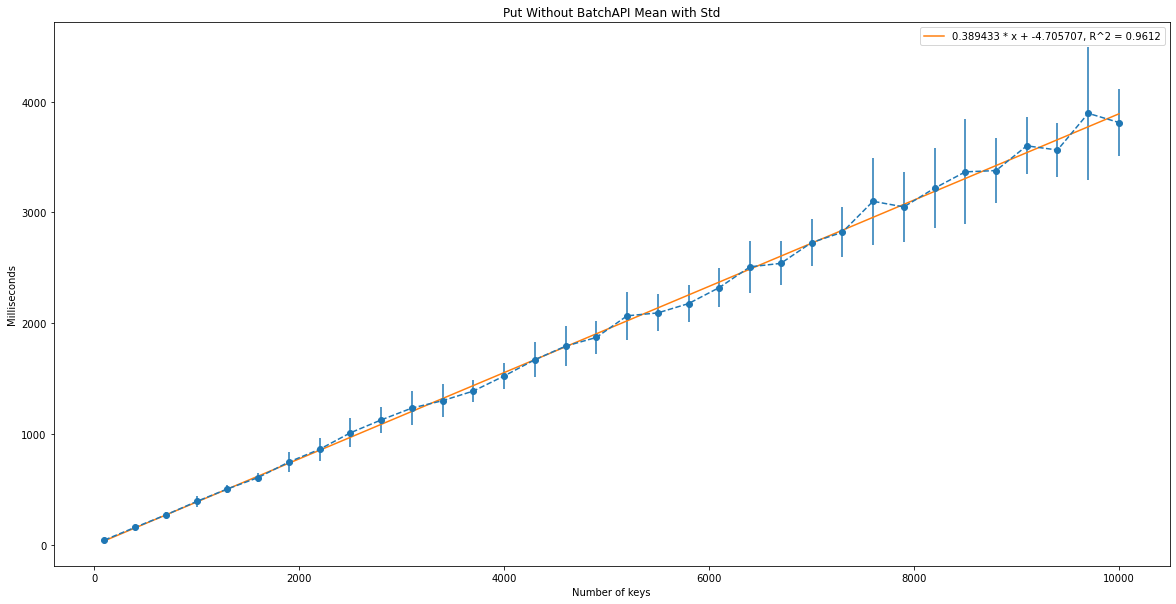

In [598]:
[r2, interc, coef] = linear_regression(putTestDfNoBatch)

plot_error_bars(putTestDfNoBatch.groupby('entries'), "Put Without BatchAPI Mean with Std", coef, interc, r2)

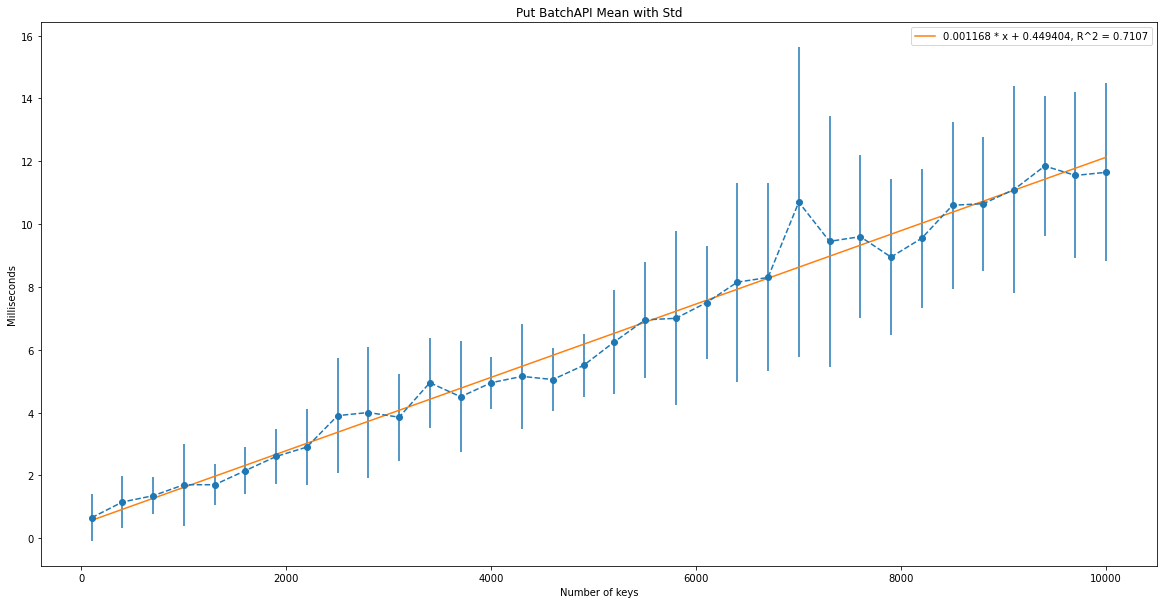

In [599]:
[r2, interc, coef] = linear_regression(putTestDfBatch)
plot_error_bars(putTestDfBatch.groupby('entries'), "Put BatchAPI Mean with Std", coef, interc, r2)

In [600]:
# Function to plot data with two lines
def compare_plot(dfgroup1, label1, dfgroup2, label2, title):
    mean1 = np.array(dfgroup1.mean()['millis'])
    std1 = np.array(dfgroup2.std()['millis'])
    mean2 = np.array(dfgroup2.mean()['millis'])
    std2 = np.array(dfgroup1.std()['millis'])
    entries = [name for name, _ in dfgroup1]
    plt.title(title)
    plt.xlabel("Number of keys")
    plt.ylabel("Milliseconds")
    plt.plot(entries, mean1, '--o', label=label1)
    plt.plot(entries, mean2, "--o", label=label2)
    plt.legend()
    plt.show()

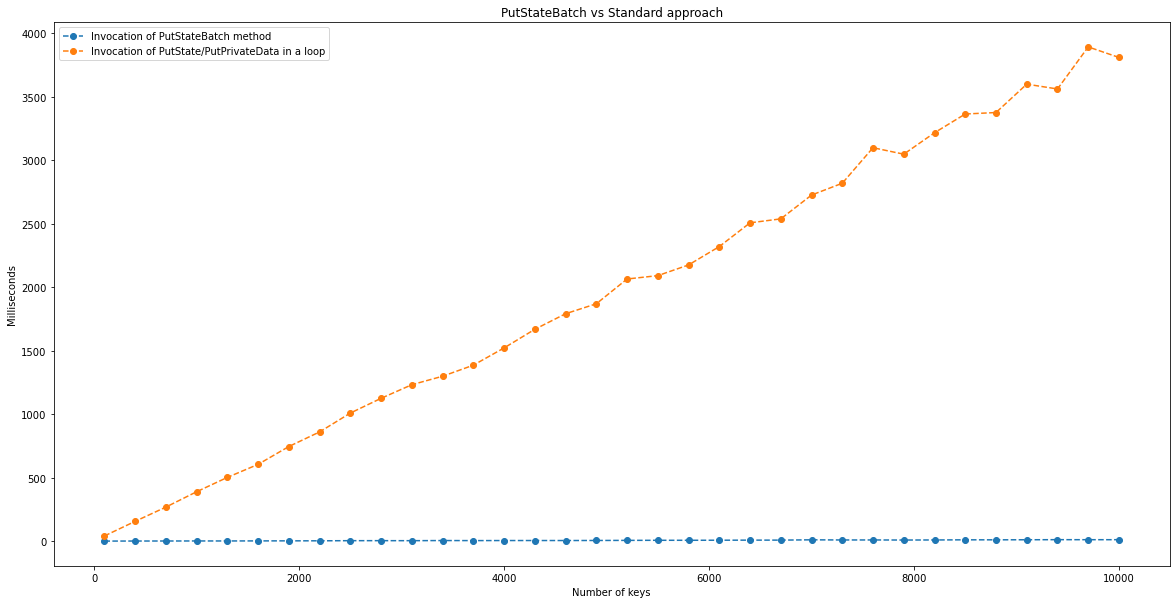

In [601]:
compare_plot(putTestDfBatch.groupby('entries'), 'Invocation of PutStateBatch method', putTestDfNoBatch.groupby('entries'), 'Invocation of PutState/PutPrivateData in a loop', "PutStateBatch vs Standard approach")

### Рассмотрим случай обращения к относительно небольшому числу ключей

In [602]:
nkeys_files = [f for f in stress_files if f.startswith("stressPut") and ('Del' not in f) and ('10-10-100' in f)]
nkeys_files[:5]

['stressPut10-10-10-100.KeyLen20.log',
 'stressPut1-10-10-100.KeyLen20.log',
 'stressPut6-10-10-100.KeyLen20.log',
 'stressPut5-10-10-100.KeyLen20.log',
 'stressPut2-10-10-100.KeyLen20.log']

In [603]:
def few_keys_plot(files, method, batchLegend, noBatchLegend, title, line_lims):
    tests = []

    readFiles(files, tests)
    testDf = pd.DataFrame.from_records(tests)
    testDf = testDf.loc[testDf["method"] == method]
    testDfBatch = testDf.loc[testDf['batchapi'] == True]
    testDfNoBatch = testDf.loc[testDf['batchapi'] == False]

    plt.figure()
    [r2, interc, coef] = linear_regression(testDfBatch)
    plot_error_bars(testDfBatch.groupby('entries'), method.capitalize() + " BatchAPI Mean with Std", coef, interc, r2, np.array(line_lims))
    plt.figure()
    [r2, interc, coef] = linear_regression(testDfNoBatch)
    plot_error_bars(testDfNoBatch.groupby('entries'), method.capitalize() + " Without BatchAPI Mean with Std", coef, interc, r2, np.array(line_lims))
    plt.figure()
    compare_plot(testDfBatch.groupby('entries'), 
                 batchLegend, 
                 testDfNoBatch.groupby('entries'), 
                 noBatchLegend, 
                 title)

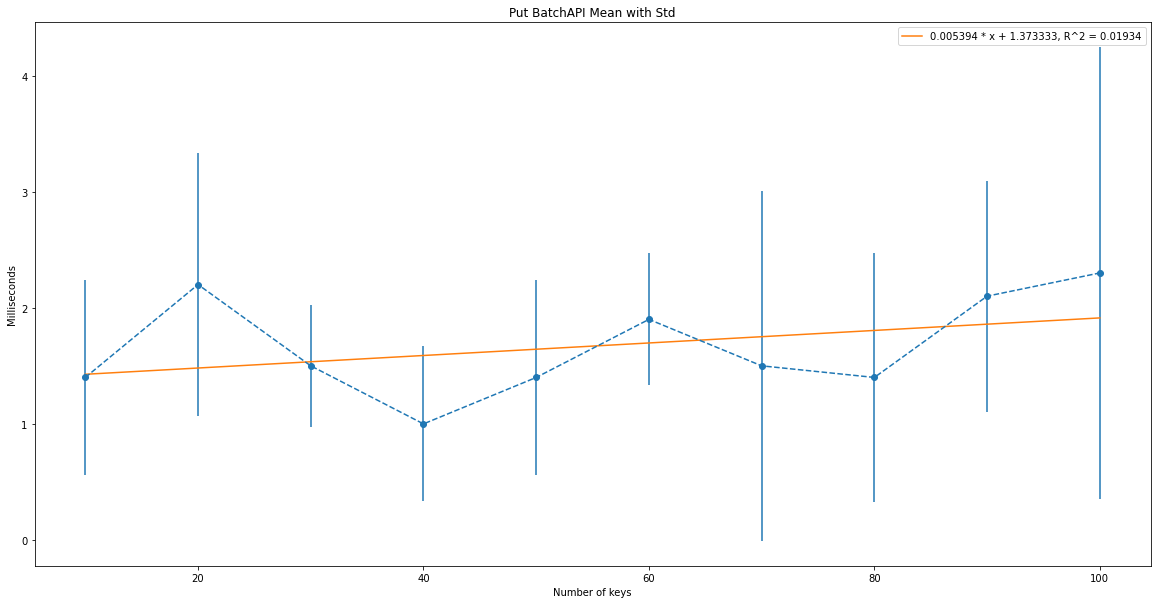

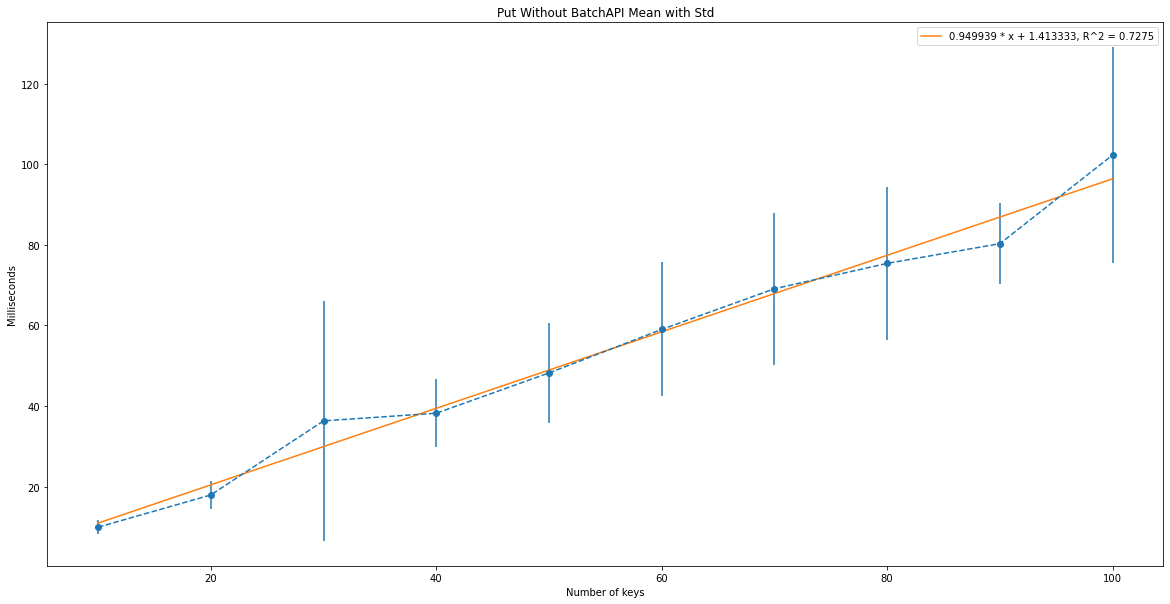

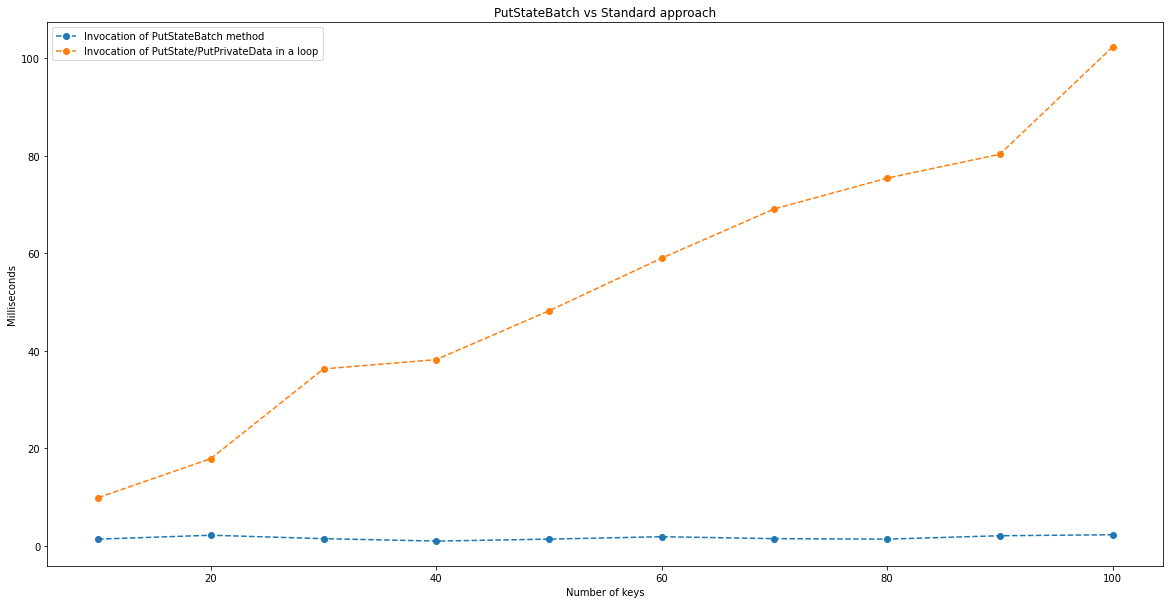

In [629]:
few_keys_plot(nkeys_files, "put", 
              "Invocation of PutStateBatch method", 
              "Invocation of PutState/PutPrivateData in a loop", 
              "PutStateBatch vs Standard approach", [10, 100])

## Кейс: DelState vs DelStateBatch
Проанализируем данные, где происходит удаление данных из леджера

In [605]:
del_files = [f for f in stress_files if ("PutAndDel" in f) and ("100-300-10000") in f]
del_files[:5]

['stressPutAndDel1-100-300-10000.KeyLen20.log',
 'stressPutAndDel6-100-300-10000.KeyLen20.log',
 'stressPutAndDel9-100-300-10000.KeyLen20.log',
 'stressPutAndDel5-100-300-10000.KeyLen20.log',
 'stressPutAndDel2-100-300-10000.KeyLen20.log']

In [606]:
del_tests = []

readFiles(del_files, del_tests)

delTestDf = pd.DataFrame.from_records(del_tests)
delTestDf.head()

,method,entries,millis,keylen,batchapi,collection,seed
0,put,100,1,20,True,,10
1,del,100,1,20,True,,10
2,put,400,2,20,True,,10
3,del,400,1,20,True,,10
4,put,700,2,20,True,,10


In [607]:
# We need only "method=del" data
delTestDf = delTestDf.loc[delTestDf["method"] == "del"]
delTestDf.head()

,method,entries,millis,keylen,batchapi,collection,seed
1,del,100,1,20,True,,10
3,del,400,1,20,True,,10
5,del,700,2,20,True,,10
7,del,1000,3,20,True,,10
9,del,1300,1,20,True,,10


In [608]:
# Get entries with BatchAPI
delTestDfBatch = delTestDf.loc[delTestDf['batchapi'] == True]
delTestDfBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
1,del,100,1,20,True,,10
3,del,400,1,20,True,,10
5,del,700,2,20,True,,10
7,del,1000,3,20,True,,10
9,del,1300,1,20,True,,10


In [609]:
# Get entries without use of BatchAPI
delTestDfNoBatch = delTestDf.loc[delTestDf['batchapi'] == False]
delTestDfNoBatch.head()

,method,entries,millis,keylen,batchapi,collection,seed
137,del,100,50,20,False,,10
139,del,400,151,20,False,,10
141,del,700,253,20,False,,10
143,del,1000,377,20,False,,10
145,del,1300,483,20,False,,10


In [610]:
# BatchAPI Del invocations mean by entries
delTestBatchMean = delTestDfBatch.groupby(['entries']).mean()
delTestBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,0.636364,20.0,True,10.0
400,0.818182,20.0,True,10.0
700,1.454545,20.0,True,10.0
1000,2.363636,20.0,True,10.0
1300,2.090909,20.0,True,10.0


In [611]:
# Without use of BatchAPI Del invocations mean by entries
delTestNoBatchMean = delTestDfNoBatch.groupby(['entries']).mean()
delTestNoBatchMean.head()

,millis,keylen,batchapi,seed
entries,,,,
100,41.666667,20.0,False,10.0
400,166.777778,20.0,False,10.0
700,290.000000,20.0,False,10.0
1000,406.000000,20.0,False,10.0
1300,570.555556,20.0,False,10.0


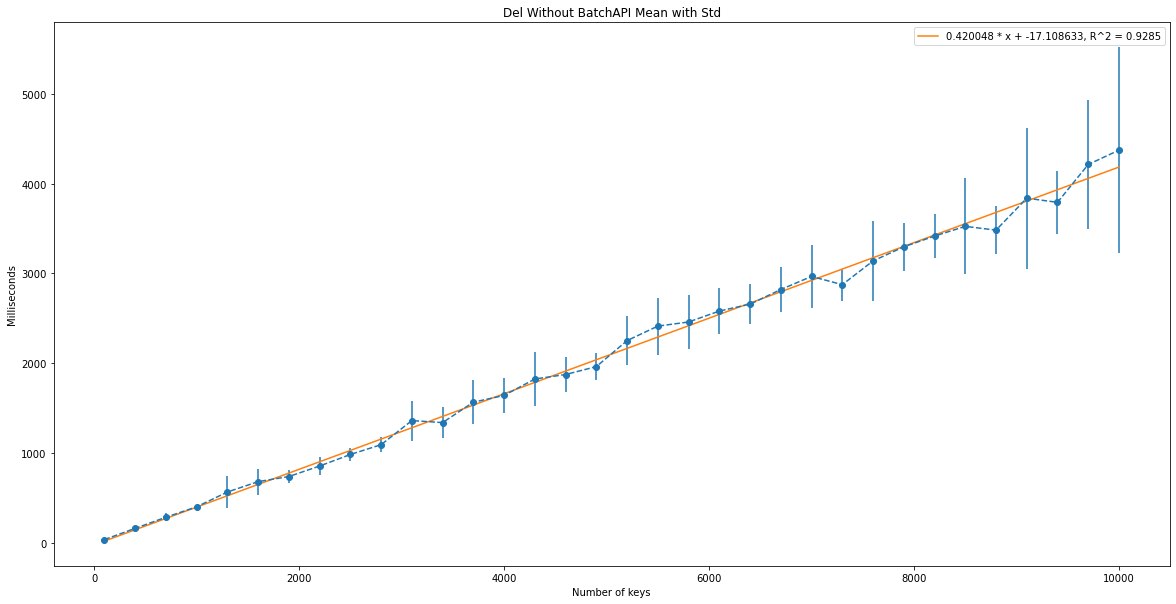

In [612]:
[r2, interc, coef] = linear_regression(delTestDfNoBatch)

plot_error_bars(delTestDfNoBatch.groupby('entries'), "Del Without BatchAPI Mean with Std", coef, interc, r2)

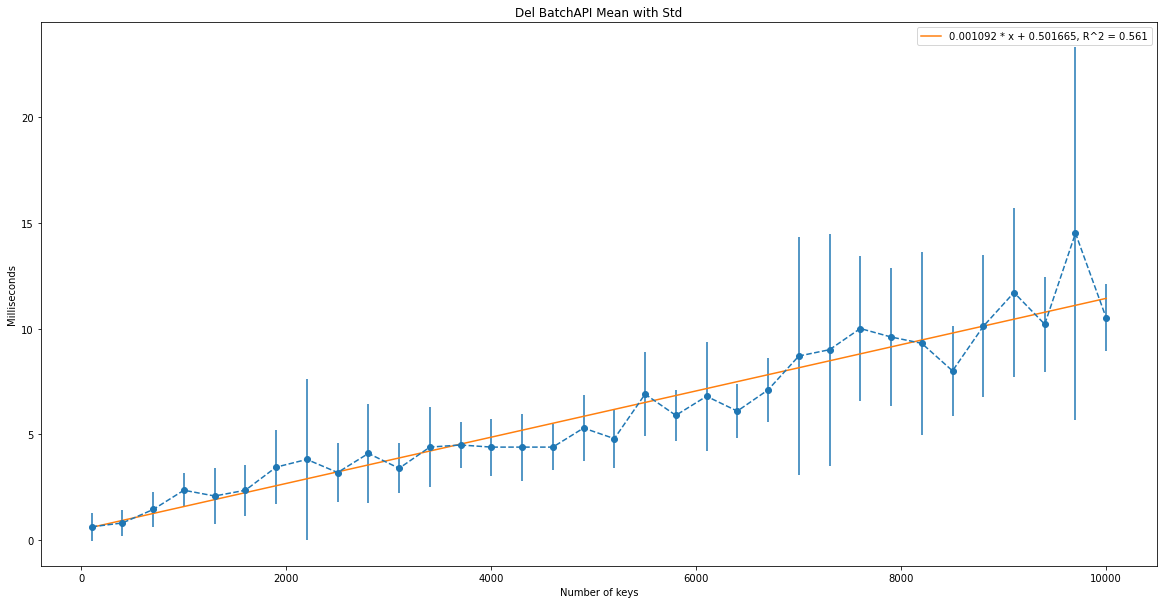

In [613]:
[r2, interc, coef] = linear_regression(delTestDfBatch)
plot_error_bars(delTestDfBatch.groupby('entries'), "Del BatchAPI Mean with Std", coef, interc, r2)

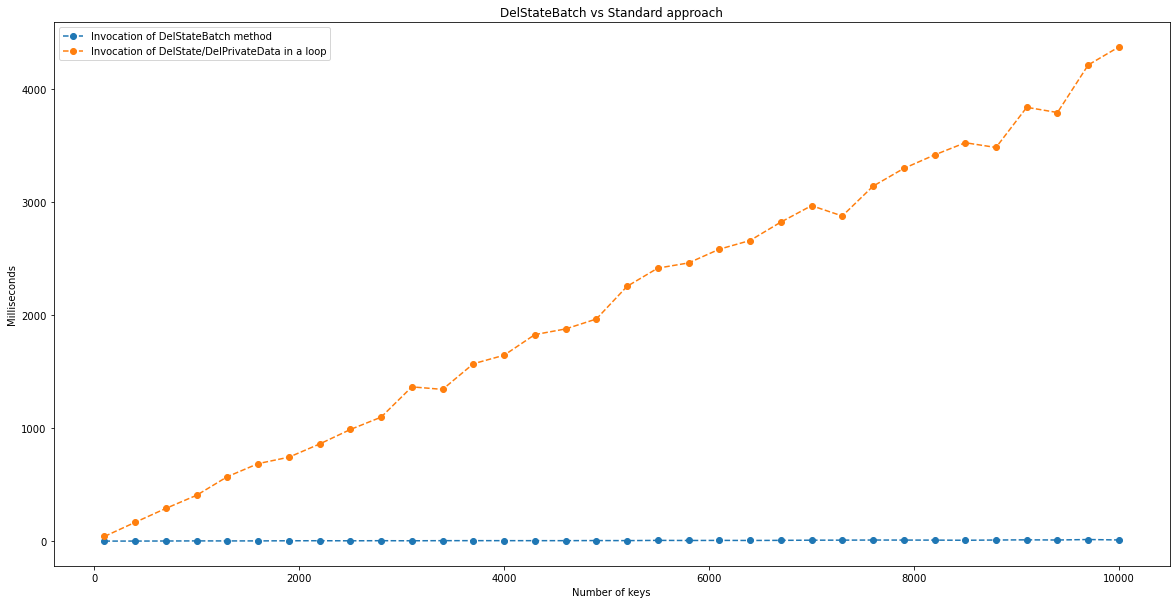

In [614]:
compare_plot(delTestDfBatch.groupby('entries'), 'Invocation of DelStateBatch method', delTestDfNoBatch.groupby('entries'), 'Invocation of DelState/DelPrivateData in a loop', "DelStateBatch vs Standard approach")

### Рассмотрим случай обращения к относительно небольшому числу ключей DelState

In [615]:
putdel_files = [f for f in stress_files if ("PutAndDel" in f) and ("5-5-100") in f]
putdel_files[:5]

['stressPutAndDel9-5-5-100.KeyLen20.log',
 'stressPutAndDel3-5-5-100.KeyLen20.log',
 'stressPutAndDel6-5-5-100.KeyLen20.log',
 'stressPutAndDel2-5-5-100.KeyLen20.log',
 'stressPutAndDel7-5-5-100.KeyLen20.log']

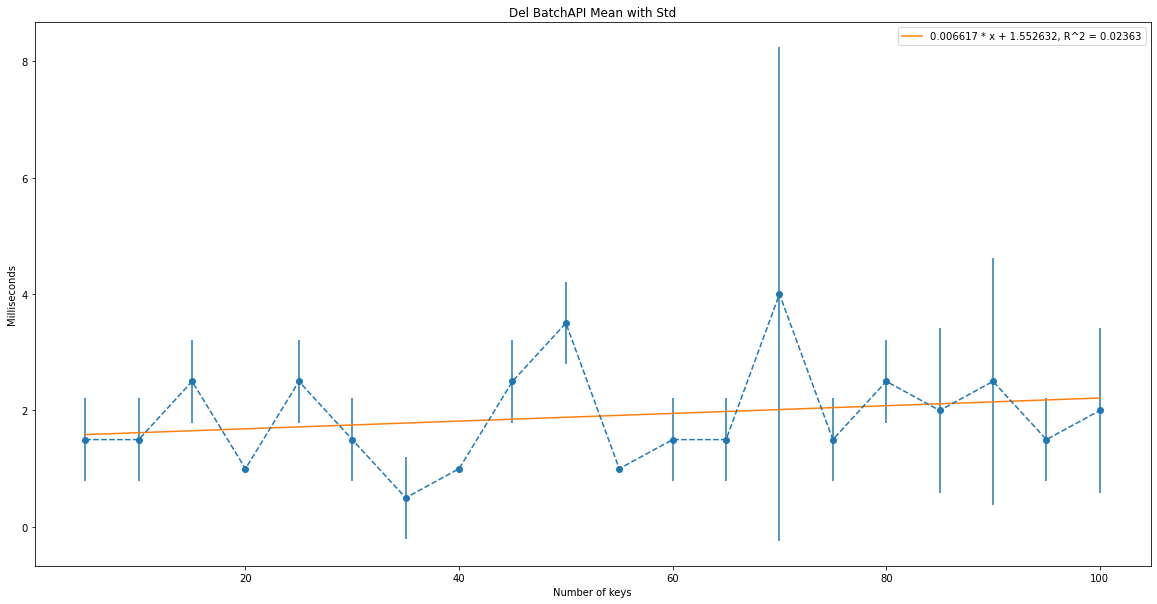

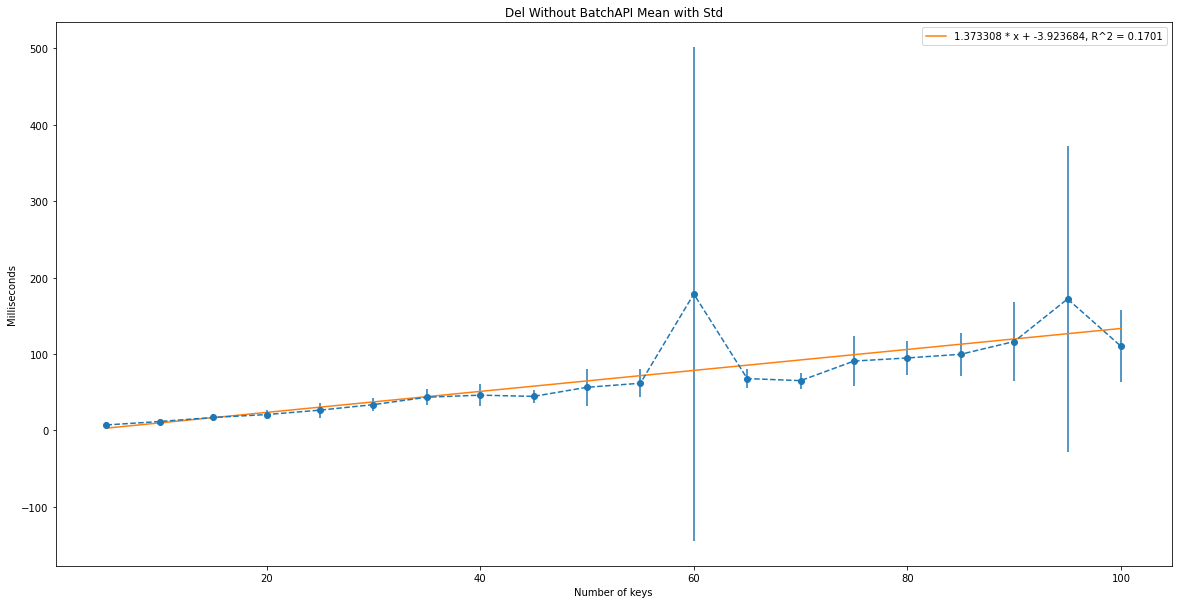

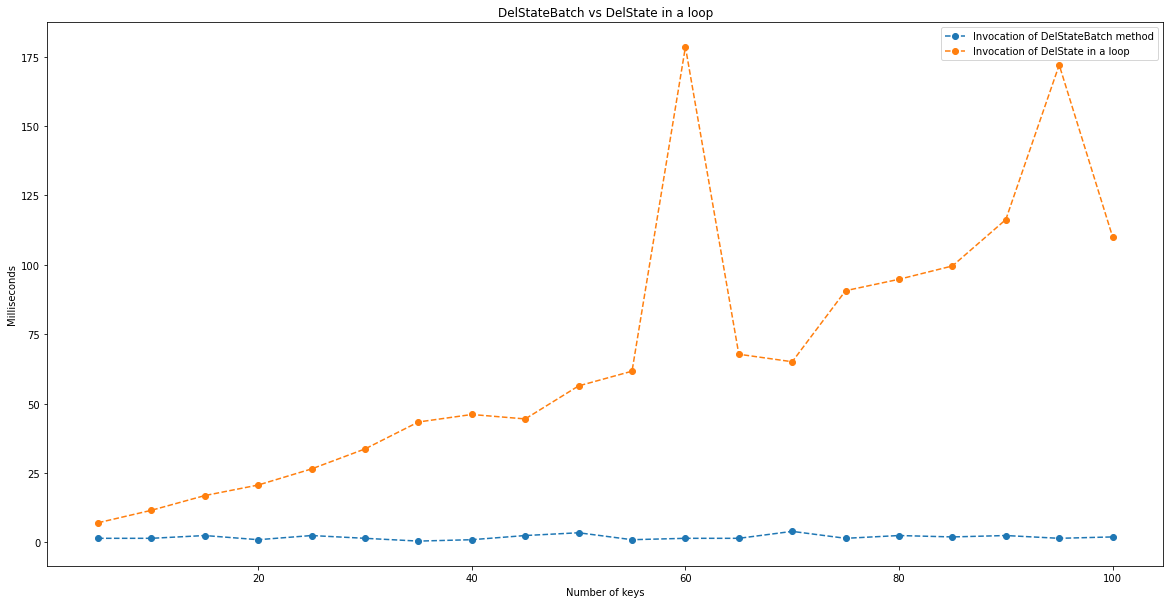

In [616]:
few_keys_plot(putdel_files, "del", 
              "Invocation of DelStateBatch method", 
              "Invocation of DelState in a loop", 
              "DelStateBatch vs DelState in a loop", [5, 100])

## Кейс: GetRange vs GetStateBatch
Проанализируем данные, где происходит чтение данных GetStateByRange и GetStateBatch

In [617]:
getrange_files = [f for f in stress_files if ("GetRangeVSBatchAPI" in f) and ("100-300-10000") in f]
getrange_files[:5]

['scenarioGetRangeVSBatchAPI9-100-300-10000.log',
 'scenarioGetRangeVSBatchAPI8-100-300-10000.log',
 'scenarioGetRangeVSBatchAPI10-100-300-10000.log',
 'scenarioGetRangeVSBatchAPI6-100-300-10000.log',
 'scenarioGetRangeVSBatchAPI3-100-300-10000.log']

In [618]:
getrange_tests = []

readFiles(getrange_files, getrange_tests)
rangeTestDf = pd.DataFrame.from_records(getrange_tests)
rangeTestDf.head()

,method,entries,millis,batchapi
0,getrange,100,2,False
1,getrange,100,3,True
2,getrange,400,7,False
3,getrange,400,3,True
4,getrange,700,20,False


In [619]:
# We need only "method=getrange" data (in case of inconsistent data)
rangeTestDf = rangeTestDf.loc[rangeTestDf["method"] == "getrange"]
rangeTestDf.head()

,method,entries,millis,batchapi
0,getrange,100,2,False
1,getrange,100,3,True
2,getrange,400,7,False
3,getrange,400,3,True
4,getrange,700,20,False


In [620]:
# Get entries with BatchAPI
rangeTestDfBatch = rangeTestDf.loc[rangeTestDf['batchapi'] == True]
rangeTestDfBatch.head()

,method,entries,millis,batchapi
1,getrange,100,3,True
3,getrange,400,3,True
5,getrange,700,6,True
7,getrange,1000,9,True
9,getrange,1300,8,True


In [621]:
# Get entries without use of BatchAPI
rangeTestDfNoBatch = rangeTestDf.loc[rangeTestDf['batchapi'] == False]
rangeTestDfNoBatch.head()

,method,entries,millis,batchapi
0,getrange,100,2,False
2,getrange,400,7,False
4,getrange,700,20,False
6,getrange,1000,24,False
8,getrange,1300,36,False


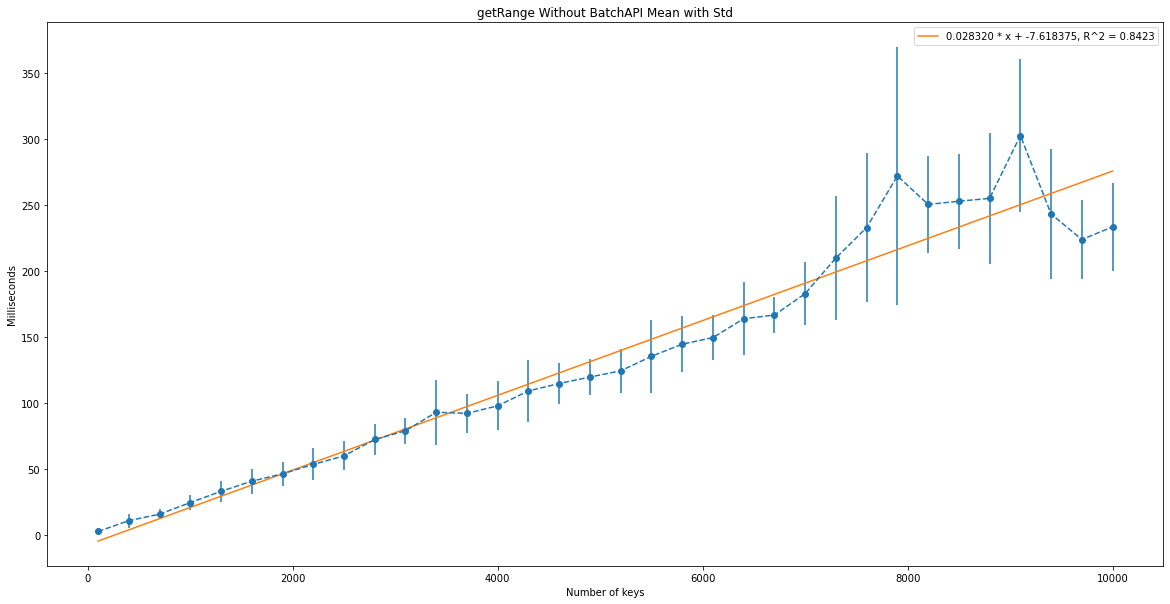

In [622]:
[r2, interc, coef] = linear_regression(rangeTestDfNoBatch)

plot_error_bars(rangeTestDfNoBatch.groupby('entries'), "getRange Without BatchAPI Mean with Std", coef, interc, r2)

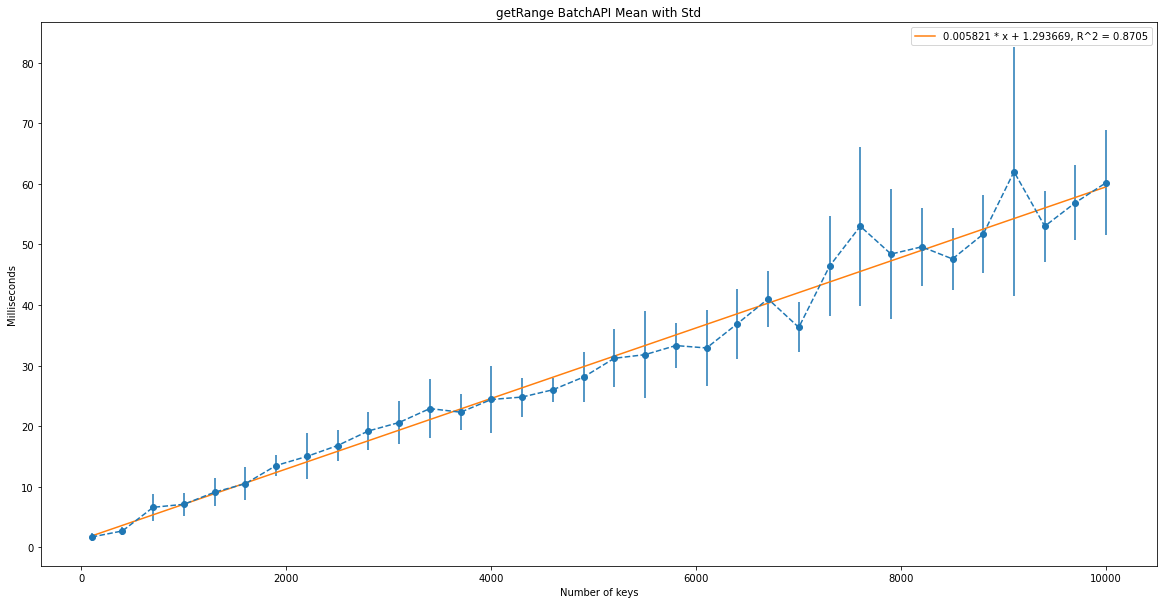

In [623]:
[r2, interc, coef] = linear_regression(rangeTestDfBatch)
plot_error_bars(rangeTestDfBatch.groupby('entries'), "getRange BatchAPI Mean with Std", coef, interc, r2)

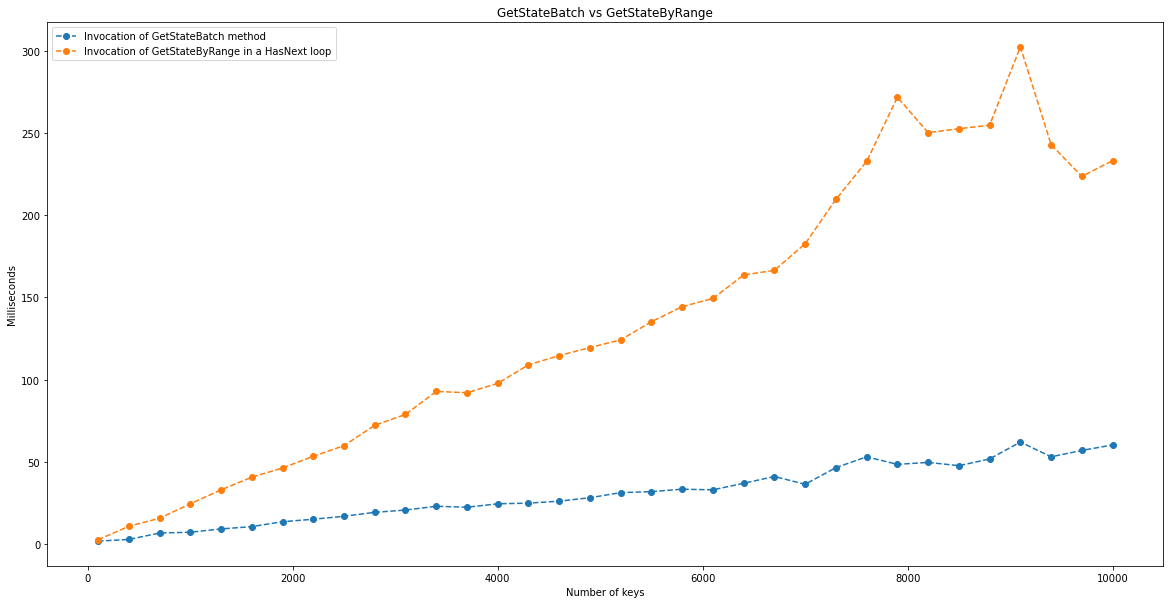

In [624]:
compare_plot(rangeTestDfBatch.groupby('entries'), 'Invocation of GetStateBatch method', rangeTestDfNoBatch.groupby('entries'), 'Invocation of GetStateByRange in a HasNext loop', "GetStateBatch vs GetStateByRange")

### Рассмотрим случай обращения к относительно небольшому числу ключей GetRange

In [625]:
smallrange_files = [f for f in stress_files if ("GetRangeVSBatchAPI" in f) and ("10-10-100") in f]
smallrange_files[:5]

['scenarioGetRangeVSBatchAPI8-10-10-100.log',
 'scenarioGetRangeVSBatchAPI2-10-10-100.log',
 'scenarioGetRangeVSBatchAPI10-10-10-100.log',
 'scenarioGetRangeVSBatchAPI6-10-10-100.log',
 'scenarioGetRangeVSBatchAPI1-10-10-100.log']

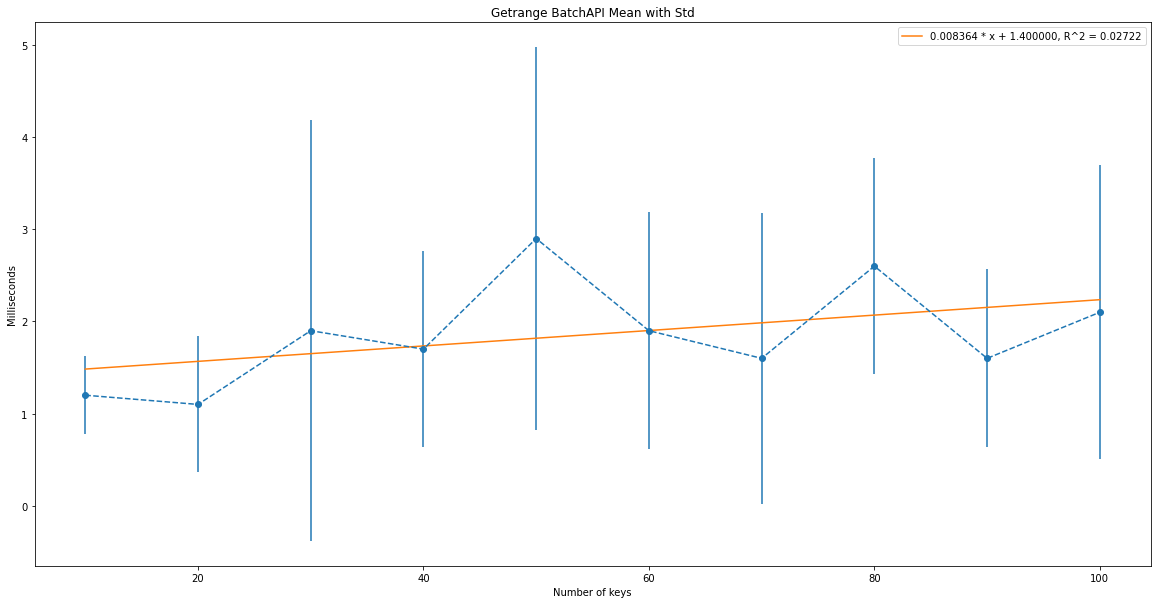

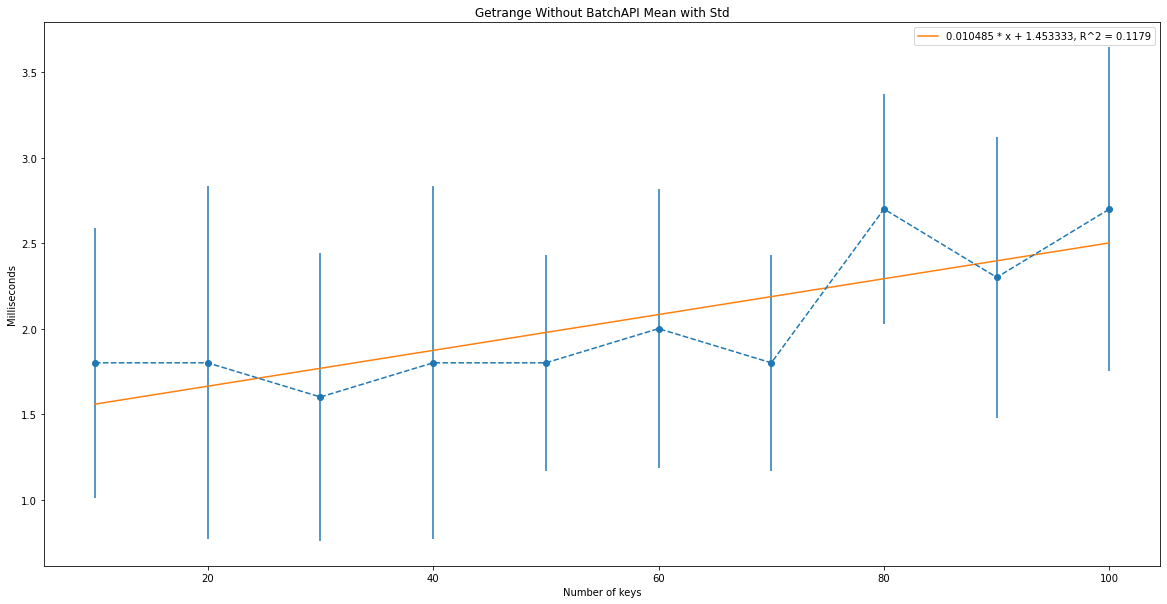

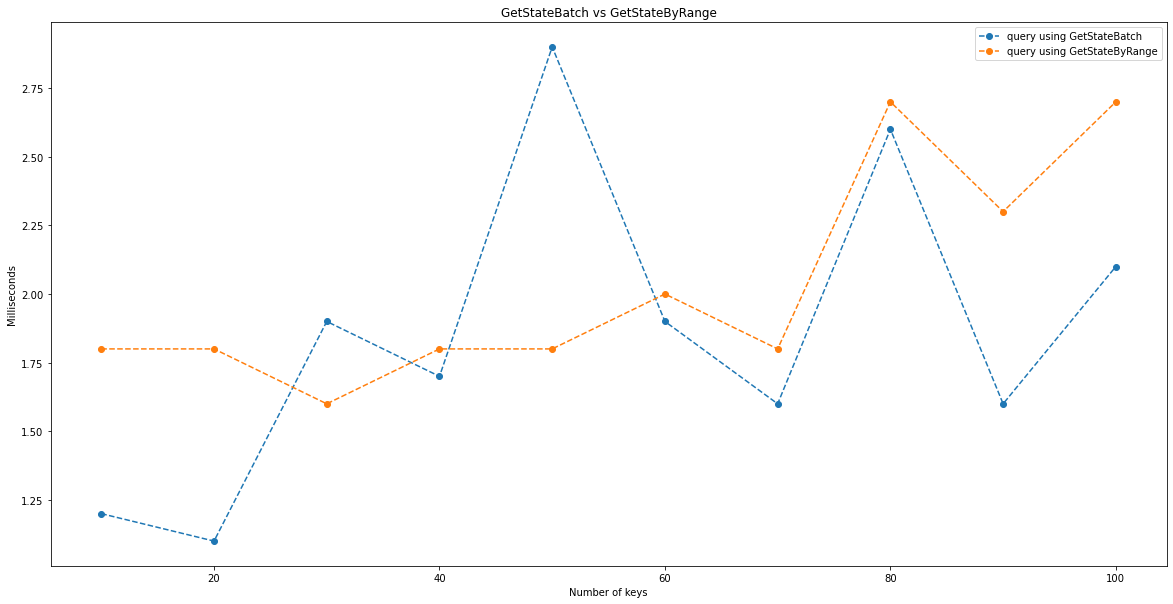

In [628]:
few_keys_plot(smallrange_files, "getrange", 
              "query using GetStateBatch", 
              "query using GetStateByRange", 
              "GetStateBatch vs GetStateByRange", [10, 100])